### Tests
Use of the agglomerative clustering with HR diagram.

The dirty work is done in gaia_utils...

In [15]:
import sys, os
sys.path.append('../../src')


import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd

from math import ceil
import gaia_utils as gu
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

%matplotlib inline

## directory
rootdir = "/home/stephane/Science/GAIA"
wdir    = "%s/products"%(rootdir)
datadir = "%s/master/notebooks/data"%(rootdir)

os.chdir(wdir)
rcParams['figure.figsize'] = 14, 14
###################################

clustername = "NGC 2682"
voname = 'NGC 2682-3.0deg.vot'
RADIUS   = 3.0
kCluster = 9
votable_disk = False
BINSIZE = 64
SIGMA = 1.0
distclust = 830.0
XYRANGE = [-20., 20]
WEIGHT = [1.,1.,10.,7.,7., 3., 3., 3.]

In [16]:
## plot2D and plot3D


def plot2d_labels(a1,a2,labels,nclusterk,centroid,xylab = ["a1","b1"], distlab = 0, title = "Title", clustername= "NGC"):
    figname = "%s-2Dkmeans-gaia.png"%(clustername)
    rcParams['figure.figsize'] = 14, 21
    nrow = int(ceil(nclust / 3))
    ncol = 3           
    f, axarr = plt.subplots(nrow, ncol)

    for i in range(nclusterk):
        ilabel = np.where(labels == i)[0]
        row = int(ceil(i / 3)) - 1
        col = i % 3
        axarr[row,col].scatter(a1[ilabel],a2[ilabel], s=1, c="#000000")
        axarr[row,col].set_xlabel(xylab[0])
        axarr[row,col].set_ylabel(xylab[1])
        
        txt = "Stars:%d Dist:%3.1f Vra:%3.1f Vdec:%3.1f"%(len(ilabel), centroid[i][distlab],centroid[i][3],centroid[i][4])
        axarr[row,col].text(-0.1,1.02, txt, size=12, ha="left", 
         transform=axarr[row,col].transAxes)
        
    plt.savefig(figname)
    plt.show()

def plot2d_filtered_labels(a1,a2,labels,nclusterk,centroid, xylab = ["a1","b1"], distlab = 0, title = "Title", clustername= "NGC" , xyrange = []):
    
    "filtering with wavelet."
    
    gaia = gu.gaiaSet()
    
    figname = "%s-2Dkmeans-filtered-gaia.png"%(clustername)
    rcParams['figure.figsize'] = 14, 21
    nrow = int(ceil(nclust / 3))
    ncol = 3           
    f, axarr = plt.subplots(nrow, ncol)

    for i in range(nclusterk):
        ilabel = np.where(labels == i)[0]
        row = int(ceil(i / 3)) - 1
        col = i % 3
        im , imf = gaia.sampling_filtering(a1[ilabel],a2[ilabel], BINSIZE, SIGMA, xrange = xyrange, yrange = xyrange)
        
        axarr[row,col].imshow(imf, cmap = 'gist_stern')
        axarr[row,col].set_xlabel(xylab[0])
        axarr[row,col].set_ylabel(xylab[1])
        
        txt = "Stars:%d Dist:%3.1f Vra:%3.1f Vdec:%3.1f"%(len(ilabel), centroid[i][distlab],centroid[i][3],centroid[i][4])
        axarr[row,col].text(-0.1,1.02, txt, size=12, ha="left", 
         transform=axarr[row,col].transAxes)
        
    plt.savefig(figname)
    plt.show()
  

In [17]:
## astrometric conversion
## 
def convert_to_cartesian(lgal, bga, dist, offCenter = [0., 0.]):
    "Convert ra,dec (ICRS) and distance (pc) to Cartesian reference. Off is the offset in Lgal,Bgal"
    
    xx = np.zeros(len(lgal))
    yy = np.zeros(len(lgal))
    zz = np.zeros(len(lgal))
    
    lgalOff = lgal - offCenter[0]
    bgalOff = bgal - offCenter[1]
    
    print(offCenter[0])
    print(offCenter[1])
    print(min(lgalOff))
    print(max(lgalOff))
    print(min(bgalOff))
    print(max(bgalOff))
    
    
    for i in range(len(lgal)):
        c = coord.SkyCoord(l=lgalOff[i]*u.degree, b=bgalOff[i]*u.degree, distance=dist[i]*u.pc, frame='galactic')
        
        xx[i] = c.cartesian.x.value
        yy[i] = c.cartesian.y.value
        zz[i] = c.cartesian.z.value
        
    print("## XX")
    print("min, max: %f , %f"%(min(xx),max(xx)))
    print("## YY")
    print("min, max: %f , %f"%(min(yy),max(yy)))
    print("## ZZ")
    print("min, max: %f , %f"%(min(zz),max(zz)))  
        
    return(xx,yy,zz)

In [18]:
## Read the data and do the conversion


source = gu.source(clustername)
source.weight = WEIGHT
# source.query(RADIUS, errtol = 0.5, dump = True)
source.read_votable(voname)
source.convert_filter_data()
source.normalization0_1()

## NGC 2682-3.0deg.vot read...
## Total stars: 61269
## Conversion done...
## Stars selected: 52822
## Normalization done on filtered data..


()

### Some plotting ...

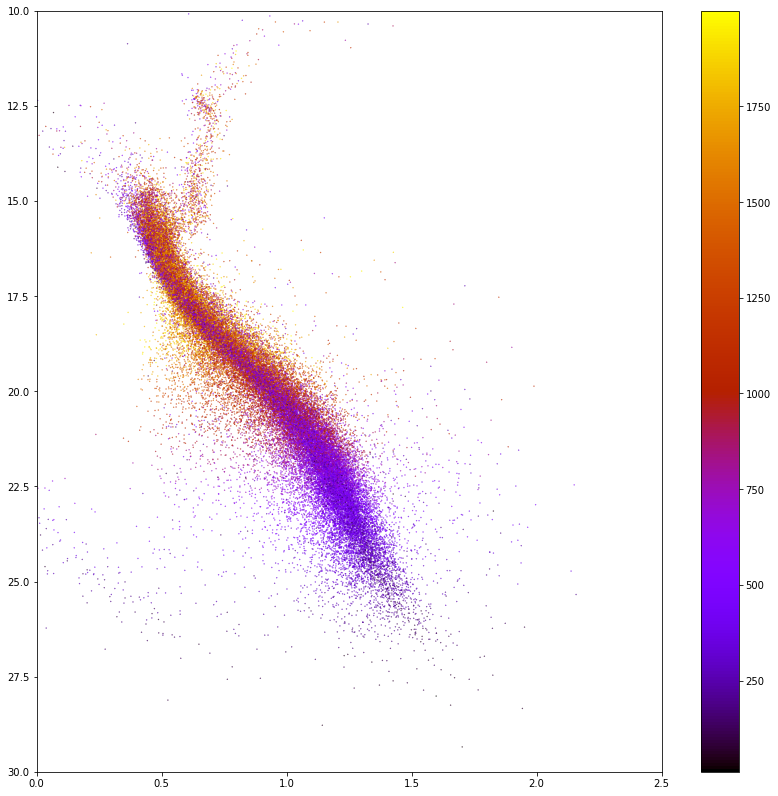

In [19]:
plt.scatter(source.df[:,6], source.df[:,5], s= 0.1, c=source.df[:,2], cmap='gnuplot')
plt.colorbar()
plt.xlim([0.,2.5])
plt.ylim([30.,10])
plt.show()



### Clustering

In [ ]:
print("## computing k-means...")

# KMeans for each normalisation
kmeans = cluster.KMeans(n_clusters= kCluster, max_iter = 2000, n_init = 50)
kmeans.fit(source.dfnorm)
centroid = kmeans.cluster_centers_
centroid_phys = source.unnormalization0_1(centroid)
labels = kmeans.labels_
for i in range(kCluster):
    print("# Label %d : %d"%(i,len(labels[np.where(labels == i)])))
print(centroid_phys[:,2])

print("## computing Ward... ")

# connectivity matrix for structured Ward

neighbors = 20
connectivity = kneighbors_graph(source.dfnorm, n_neighbors= neighbors, include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

ward = cluster.AgglomerativeClustering(n_clusters= kCluster, linkage='ward', connectivity=connectivity)
ward.fit(source.dfnorm)
labels_w = ward.labels_
for i in range(kCluster):
    print("# Label %d : %d  Dist: %f"%(i,len(labels[np.where(labels_w == i)]), np.mean(source.df[np.where(labels_w == i),2])))

## computing k-means...


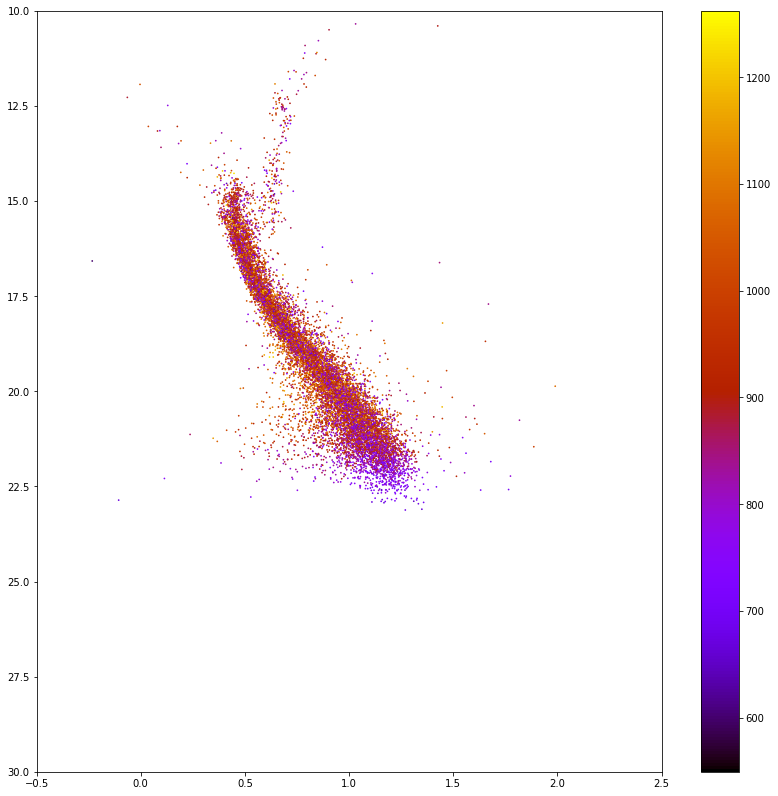

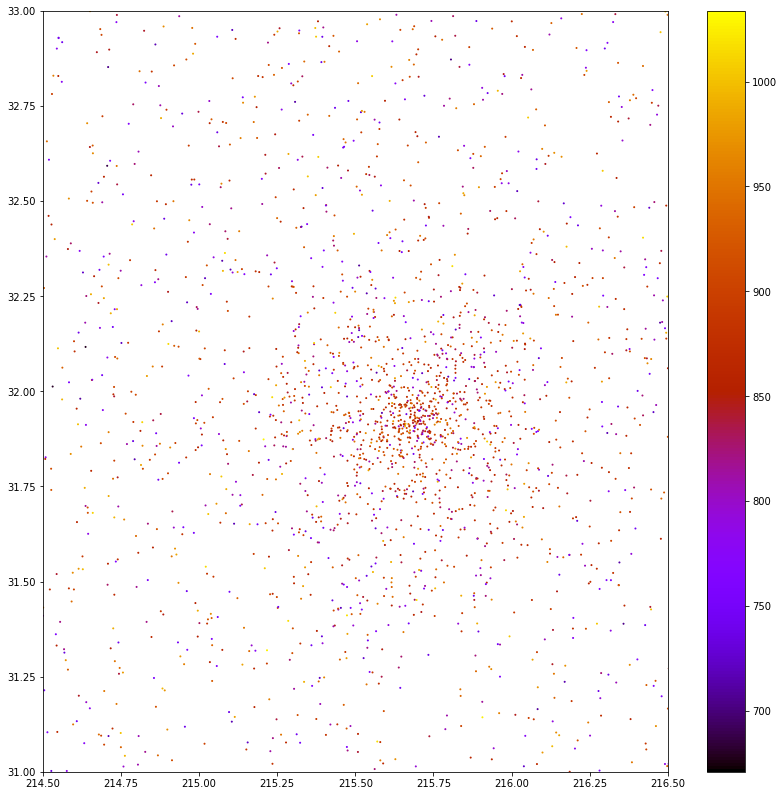

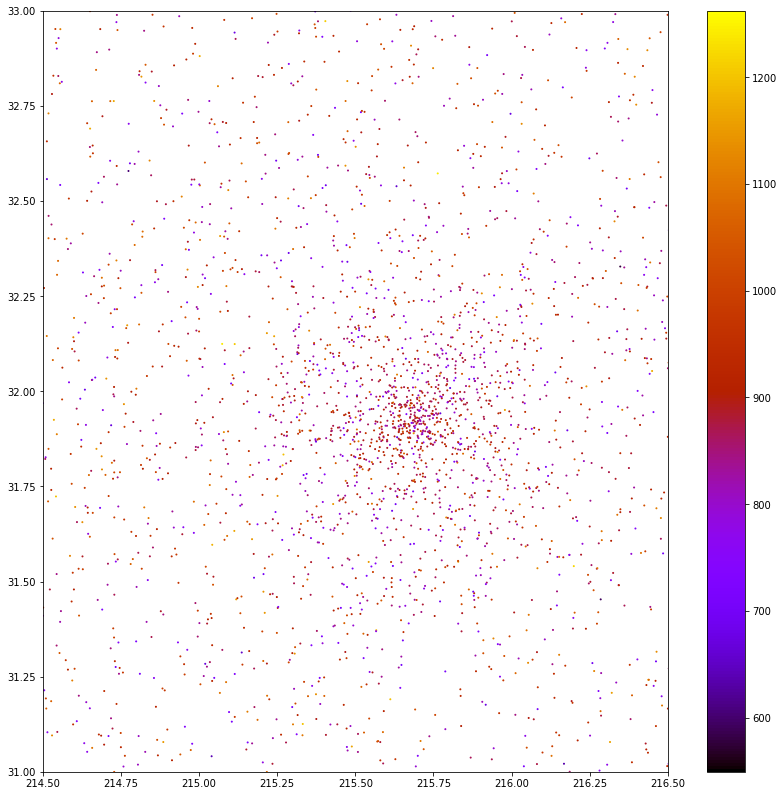

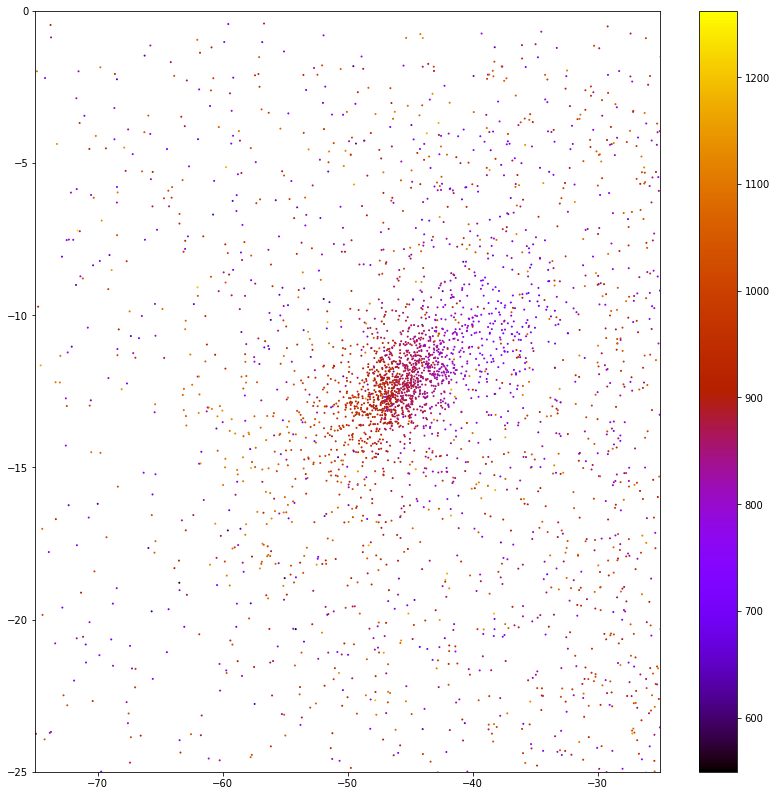

In [28]:
ilab=4
ilab2 = 1
plt.scatter(source.df[np.where(labels_w == ilab2),6], source.df[np.where(labels_w == ilab2),5], s= 0.5, c=source.df[np.where(labels_w == ilab2),2], cmap='gnuplot')
plt.colorbar()
plt.xlim([-0.5,2.5])
plt.ylim([30.,10])
plt.show()

plt.scatter(source.df[np.where(labels == ilab),0], source.df[np.where(labels == ilab),1], s= 1.0, c=source.df[np.where(labels == ilab),2], cmap='gnuplot')
plt.colorbar()
plt.xlim([214.5,216.5])
plt.ylim([31.,33.])
plt.show()


plt.scatter(source.df[np.where(labels_w == ilab2),0], source.df[np.where(labels_w == ilab2),1], s= 1.0, c=source.df[np.where(labels_w == ilab2),2], cmap='gnuplot')
plt.colorbar()
plt.xlim([214.5,216.5])
plt.ylim([31.,33.])
plt.show()

plt.scatter(source.df[np.where(labels_w == ilab2),3], source.df[np.where(labels_w == ilab2),4], s= 1.0, c=source.df[np.where(labels_w == ilab2),2], cmap='gnuplot')
plt.colorbar()
plt.xlim([-75.0,-25.])
plt.ylim([-25.,0.])
plt.show()